# 3.1 Reinforcement Learning

## Introduction

### From Unsupervised to Supervised Learning

Unsupervised learning allows a model to discover structure present in the environment. This is a powerful way to build up a *neutral* representation of the world. But a representation generated by unsupervised learning does not have any valence (positive or negative value) - it does not tell you what things in the world are good or bad for you. Such a representation might help you infer what to expect,but it does not tell you what to do.  We need a way to learn how to behave - how to make better decisions and act to optimize rewards (increase positive outcomes, decrease negative outcomes).

Attaching value to things in the world, and making decisions that can arrive at these values introduces a key opportunity for training.  Supervised learning introduces the concepts of correct and incorrect, better and worse. In supervised learning the ends alter the means; the valenced outcome can reach back to change the processing that lead up to that outcome -- and when this learning works, it leads to better future decisions and outcomes.                       


### Predictions are Hard

At first pass, the only way to make accurate predictions is to travel backward in time. When you first receive a chocolate icecream cone your entire life lead up to this momentous occasion - what part of your life should be credited as its predictor?  Less extravagantly, even the few minutes before getting the icecream your natural environment contained an incredible amount of information and your brain cycled through a vast number of different states.  What feature of the environment might guide you to future icecream cones?  Which stimuli and brain states were the predictors?  Figuring this out is known as the *credit assignment problem*; it's an extremely hard problem to solve, and we'll return to it repeatedly in this course.

In order to survive, animals need to pursue rewarding things like food and avoid harmful things like getting attacked by other animals. Any ability to predict reward or punishment is generally helpful. Prediction requires associating a reward or punishment with things that consistently precede it.  If seeing over-ripe fruit on the ground is correlated with later finding ripe fruit above in the tree, the neutral stimulus of rotting fruit on the ground should teach you to look up for a rewarding piece of ripe fruit. (In behaviorist jargon, the rotting fruit on the ground begins as a neutral stimulus, looking up begins as an unconditioned response and the fruit in the tree is an unconditioned stimulus -- after learning, the rotting fruit is a conditioned stimulus and looking up is a conditioned response.) If an animal growling is correlated with that animal then attacking, hearing growling should make you prepare for an attack.  

How might animals learn to accurately predict rewards? Neural activity associated with a reward could gradually become associated with stimuli that precede the reward. Remember that with Hebbian Learning "neurons that fire together, wire together" and this can operate over both **spatial and temporal proximity**. Temporal proximity can potentially give us prediction. If a small red circle always appears right before a large chocolate icecream cone, the reward signal produced by the icecream cone could eventually become correlated with the small red circle.   
        

### Temporal Difference Learning

Temporal difference learning is a method that facilitates the backward propagation of predictions through a temporal representation. While it does not literally enable predictions to travel backward in time, it effectively allows them to update prior estimates based on subsequent outcomes, refining the temporal representation of events.

We start with a temporal sequence of stimuli: A->B->C->D. Let's call stimuli distributed over time *events*. Hebbian learning allows us to build up a neutral representation of this temporal sequence of events. Now, at time point D you get a reward. We want to associate the earliest event that reliably predicts this reward with the reward. Temporal difference learning is a way to transfer the prediction backward from D to C, from C to B, and ultimately from B to A.  


The key to understanding temporal difference learning is to shift from viewing time as a chronological construct to conceptualizing it as a linear sequence of events. This linear representation consists of stimulus events interspersed with intervals of waiting. If we imagine time flowing from left (past) to right (future), the objective is to enable information about rewards to propagate from right (future) to left (past) in order to generate accurate predictions.

**Installation and Setup**

In [1]:
%%capture
%pip install psyneulink

import numpy as np
import psyneulink as pnl
import matplotlib.pyplot as plt 

## Temporal Difference Learning from Prediction Errors

In this lab, we will be recreating the model of mesolimbic dopamine cell activity during monkey conditioning proposed by [Montague, Dayan, and Sejnowski (1996)](https://doi.org/10.1523/JNEUROSCI.16-05-01936.1996). This model compares temporal difference learning from prediction errors to physiological data. We'll use this model to replicate Figure 5 from the paper.

![Montague et al., 1996, Figure 5](montague_fig_5.jpg)

Figure 5A is plots of ∂(t) over time for three trials during training (1, 30, and 50), where $∂(t) = r(t) + w(t)x(t) - w(t - 1)x(t - 1)$ is the difference between the stimulus value and the reward.

### Stimuli and Reward Sequence

For this experiment, the stimulus (a light) starts at timestep 41 and continues for the remainder of the trial, and the reward is delivered at timestep 54, so we'll create variables to represent that. Next, we'll create the arrays that represent the samples and targets. The sample values in this experiment stay the same across all trials, but the targets do not; every 15 trials, the reward was withheld.

In [2]:
def build_stimulus(n_trials, n_time_steps, no_reward_trials, stimulus_onset=41, reward_delivery=54):
    samples = []
    targets = []
    for trial in range(n_trials):
        # Samples (1 for stimulus_onset to end, 0 otherwise)
        sample = [0.] * n_time_steps
        for i in range(stimulus_onset, len(sample)):
            sample[i] = 1.
        samples.append(sample)
        
        # Targets (0 for all time steps except reward_delivery)
        target = [0.] * n_time_steps
        target[reward_delivery] = 1.
        if trial in no_reward_trials:
            target[reward_delivery] = 0.
        targets.append(target)

        

    return np.array(samples), np.array(targets)

In [3]:
n_time_steps = 60
n_trials = 120
no_reward_trials = {14, 29, 44, 59, 74, 89}
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

In [4]:
# We can print the samples and targets

print(f'Samples ({samples.shape}):')
print(samples)
print(f'Targets ({targets.shape}):')
print(targets)

Samples ((120, 60)):
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
Targets ((120, 60)):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


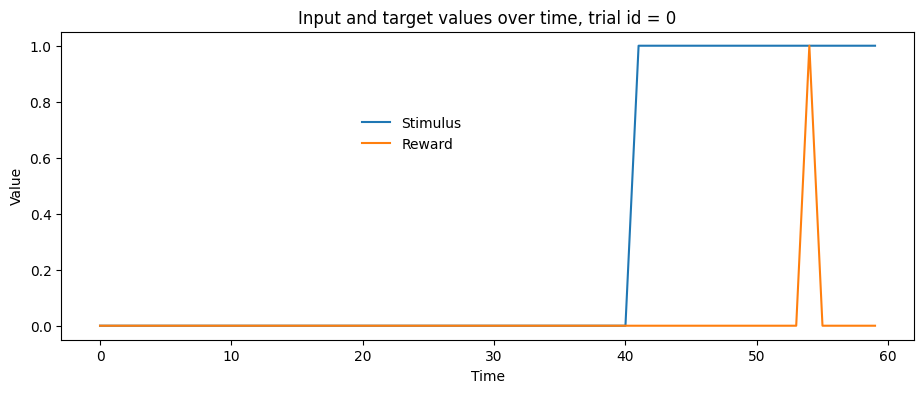

In [5]:
# We can also visualize the samples and targets for a specific trial with a line plot

trial_id = 0  # Try other ids, what do you expect to see for trial_id = 74?

f, ax = plt.subplots(1, 1, figsize=(11,4))
ax.plot(samples[trial_id,], label='Stimulus')
ax.plot(targets[trial_id,], label='Reward')

ax.set_title(f'Input and target values over time, trial id = {trial_id}')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
f.legend(bbox_to_anchor=(.5,.7),frameon=False)

Text(0.5, 0, 'Time')

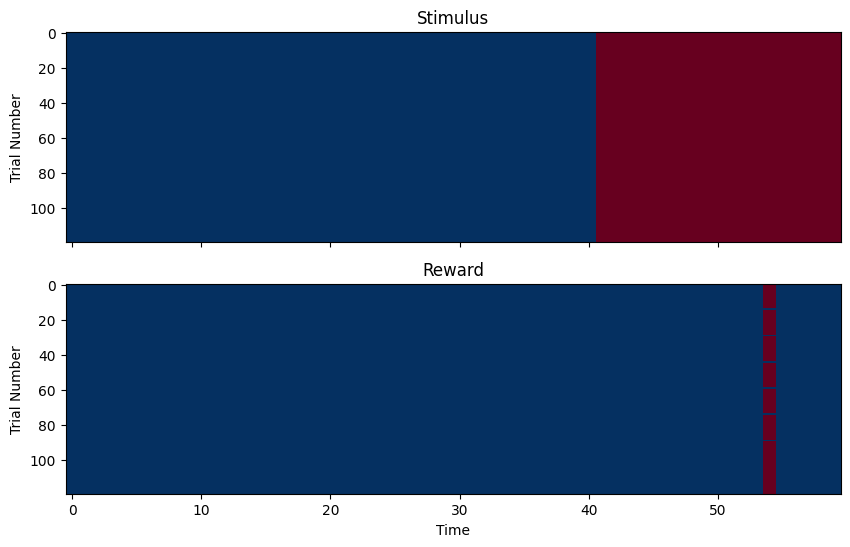

In [6]:
# Or with a heatmap (for all trials)

f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[0].set_ylabel('Trial Number')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[1].set_ylabel('Trial Number')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')

### Model Implementation - Custom Code

For each trial $i$, we first calculate the v, the prediction of the reward at each time step $t$ during the trials. This prediction is made by using the weight $w$ and the sample $x$ at time $t$:

$$
v(t) = w(t) \cdot x(t)
$$

If we write v as a vector (each element is the prediction at time $t$), we can write this as element-wise multiplication:

$$
v = w \odot x
$$

where $\odot$ is the element-wise multiplication operator.

Then, we can calculate the prediction error $\delta$ at each time step $t$ during the trials. This prediction error is the difference between the reward $r$ at time $t$ and the prediction $v$ at time $t$:

$$
\delta(t) = r(t) + v(t) - v(t - 1)
$$

Again, we can write this in vector form. Here we use $v_{t-1}$ to represent the prediction at time $t-1$:

$$
\delta = r + v - v_{t-1}
$$

Now, we calculate the new weight $w_{next}$ at each time step $t-1$ during the trials. This new weight is the old weight $w$ at $t-1$ plus the learning rate $\alpha$ times the sample at $t-1$ and the prediction error $\delta$ at time $t$:

$$
w_{next}(t-1) = w(t-1) + \alpha \cdot x(t-1) \cdot \delta(t)
$$

vectorized:

$$
w_{next, t-1} = w_{t-1} + \alpha \cdot x_{t-1} \odot \delta
$$

Here, we store the history of weights, predictions and prediction errors in `w_all`, `v_all`, and `delta_all` respectively. We then plot the prediction errors for trials 1, 30, and 50 (starting at time step 35) to compare with the figure from the paper.

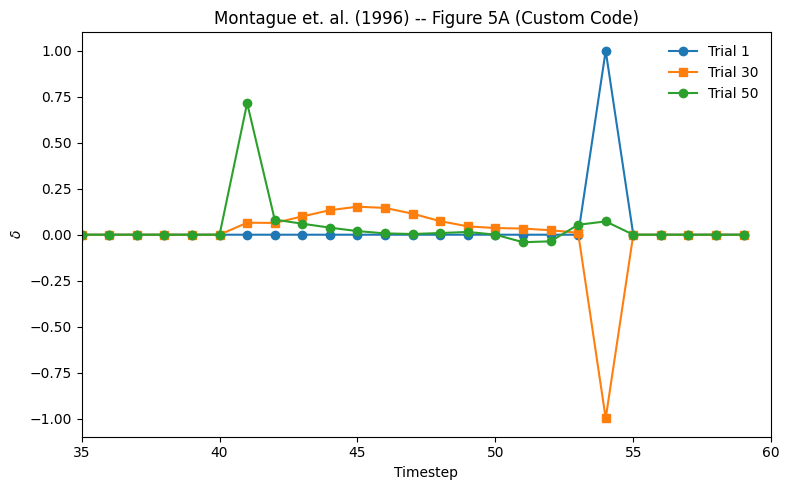

In [7]:
learning_rate = 0.3

# Initialize weights, predictions, and prediction errors
w_s = [0] * 60

# Lists to store the history
w_all = []
v_all = []
delta_all = []

# One trial
def run_trial(w_prev, s, r):
    w_next = [w for w in w_prev]
    delta = [0] * 60

    v_next = np.multiply(w_prev, s)
    delta[1:] = r[1:] + v_next[1:] - v_next[:-1]
    w_next[:-1] = w_prev[:-1] + learning_rate * np.multiply(s[:-1], delta[1:])

    return w_next, v_next, delta

# Run all trials
for sample, target in zip(samples, targets):
    w_s, v_s, delta = run_trial(w_s, sample, target)
    # Store the history
    w_all.append(w_s)
    v_all.append(v_s)
    delta_all.append(delta)

# Plot Delta Values form trials 1, 30, and 50
t_start = 35
fig = plt.figure(figsize=(8, 5))
plt.plot(delta_all[0], "-o", label="Trial 1")
plt.plot(delta_all[29], "-s", label="Trial 30")
plt.plot(delta_all[49], "-o", label="Trial 50")
plt.title("Montague et. al. (1996) -- Figure 5A (Custom Code)")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([t_start, n_time_steps])
plt.xticks()
fig.tight_layout()

## PsyNeuLink Implementation

Here, we create the model described in [Montague, Dayan, and Sejnowski (1996)](http://www.jneurosci.org/content/jneuro/16/5/1936.full.pdf). The model consists of a sample mechanism that represents the stimulus input, an action selection mechanism that represents the reward. These mechanisms are connected by a mapping projection. The projection weights are updated using temporal difference learning. The model is trained on the samples and targets we created earlier.

Since the model will be used throughout the course, we will create a function that build the model

In [8]:
def build_model(composition_name='TD_Learning_Figure_5A', 
                learning_rate=.3, 
                shape=60):
    # Create the composition
    comp = pnl.Composition(name=composition_name)

    # Create Processing Components
    sample_mechanism = pnl.TransferMechanism(
        input_shapes=shape,
        name='Sample Mechanism')

    action_selection = pnl.TransferMechanism(
        input_shapes=shape,
        function=pnl.Linear(slope=1.0, intercept=0.01),
        name='Action Selection')

    sample_to_action_selection = pnl.MappingProjection(matrix=np.zeros((shape,shape)))

    # Create pathway
    pathway = [sample_mechanism, sample_to_action_selection, action_selection]

    # Add Learning Components to the Composition
    comp.add_td_learning_pathway(pathway, learning_rate=learning_rate, name='TD Learning Pathway')
    return comp, sample_mechanism


### Visualize the Model

PsyNeuLink provides multiple ways to visualize the model. For example, we can show the graph of the composition. This graph shows the components of the model and the connections between them.

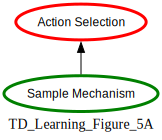

In [9]:
# Show the graph of the composition
td_comp, _ = build_model(shape=samples.shape[1])
td_comp.show_graph(output_fmt='jupyter')

To better understand what the added learning pathway does, we can show the graph with learning.

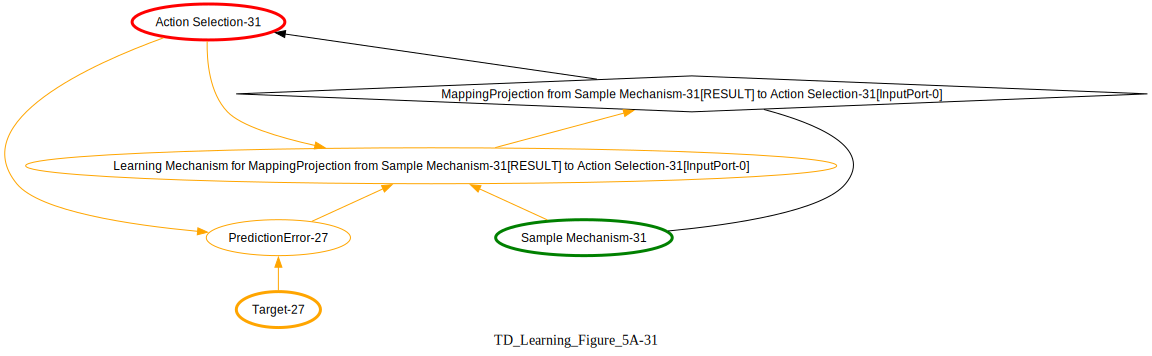

In [72]:
# Show the graph with learning
td_comp.show_graph(output_fmt='jupyter', show_learning=True)

### Create Figure 5A

Here, instead of using the `run` method, we use the `learn` method to train the model. We pass the samples and targets to the model to train it.

In [73]:
def get_learning_mechanisms(comp):
    """
    Returns the target mechanism for the learning pathway
    """
    learning_pathway = comp.pathways[0]
    learning_components = learning_pathway.learning_components

    prediction_error_mechanism = learning_components[pnl.OBJECTIVE_MECHANISM]
    prediction_error_mechanism.log.set_log_conditions(pnl.VALUE)

    target_mechanism = learning_components[pnl.TARGET_MECHANISM]
    return target_mechanism, prediction_error_mechanism

# Build Stimuli and Target
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

# Build Model
td_comp, sample_mechanism = build_model(shape=samples.shape[1])

# Get the learning mechanisms to pass targets and plot predictions
target_mechanism, prediction_error_mechanism = get_learning_mechanisms(td_comp)


input_dict = {
    sample_mechanism: samples,
    target_mechanism: targets
}

td_comp.learn(inputs=input_dict, context='execid')

array([[0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.94333984, 0.94268659, 0.94274674, 0.94556307,
        0.95299467, 0.96509316, 0.97949952, 0.99267827, 1.00204662,
        1.00717318, 1.00927162, 1.00987907, 1.00999029, 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ]])

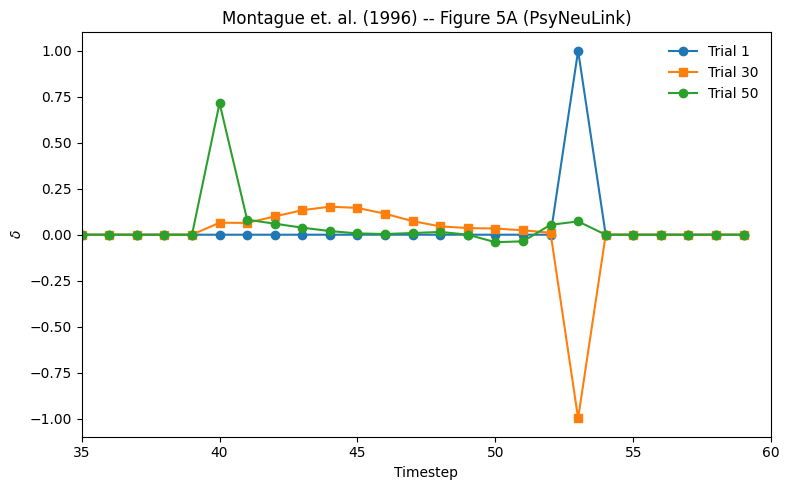

In [74]:
# Get Delta Values from Log
delta_vals = prediction_error_mechanism.log.nparray_dictionary()['execid'][pnl.VALUE]

# Plot Delta Values form trials 1, 30, and 50
t_start = 35
fig = plt.figure(figsize=(8, 5))
plt.plot(delta_vals[0][0], "-o", label="Trial 1")
plt.plot(delta_vals[29][0], "-s", label="Trial 30")
plt.plot(delta_vals[49][0], "-o", label="Trial 50")
plt.title("Montague et. al. (1996) -- Figure 5A (PsyNeuLink)")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([t_start, n_time_steps])
plt.xticks()
fig.tight_layout()

### Create Figure 5B 

Now we'll create a 3D plot from Figure 5B showing the entire time course of the experiment. According to the paper, training began at trial 10, so we'll edit the targets array to match and run the system again.  

In [75]:
# Create Stimulus Dictionary
n_time_steps = 60
n_trials = 120
no_reward_trials = {
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 29, 44, 59, 74, 89, 104, 119
}

samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)
td_comp, sample_mechanism = build_model(shape=samples.shape[1])
target_mechanism, prediction_error_mechanism = get_learning_mechanisms(td_comp)

input_dict = {
    sample_mechanism: samples,
    target_mechanism: targets
}

td_comp.learn(inputs=input_dict)

array([[0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.94333074, 0.94261968, 0.94232084, 0.94357618,
        0.94604067, 0.94654915, 0.94163884, 0.93378387, 0.9333365 ,
        0.94887368, 0.97526358, 0.99767106, 1.00795562, 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ]])

Plot the results:

Text(0.5, 0.92, 'Montague et. al. (1996) -- Figure 5B')

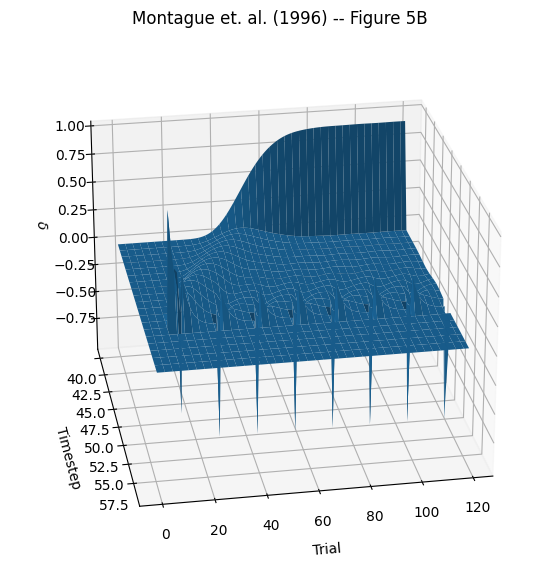

In [76]:
# Get Delta Values from Log
delta_vals = np.squeeze(
    prediction_error_mechanism.log.nparray_dictionary()[td_comp.name][pnl.VALUE]
)

t_start = 40
x_vals, y_vals = np.meshgrid(
    np.arange(n_trials), np.arange(t_start, n_time_steps))
d_vals = delta_vals[:, t_start:n_time_steps].T

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(25, 80)
ax.plot_surface(x_vals, y_vals, d_vals, linewidth=.5)
ax.invert_xaxis()
ax.set_xlabel("\nTrial")
ax.set_ylabel("\nTimestep")
ax.set_zlabel('\n'+r"$\delta$")
ax.set_title("Montague et. al. (1996) -- Figure 5B")

This 3D figure contains a lot of information.  The z-axis is timesteps within a trial (time within trials is moving from the back "wall" toward the front of the graph).  Although we had 120 time steps in each trial, this figure is zoomed in on the action; between the onset of the stimulus at timestep 41 and the delivery of reward at timestep 54.  To first approximation the y-axis displays predictions and prediction errors -- positive values are predictions, and negative values are prediction errors (i.e. when a predicted reward was absent).  The x-axis displays all 120 trials of the experiment, progressing from left to right.  There are some prominent features in the graph.  On the back wall you can see the gradual positive build up (it looks a bit like a wave) of reward prediction accumulating at the onset of the stimulus (timestep 41, when the light turns on) -- the model is learning what it is supposed to!  Near the front left you can see predictions starting after the first trial with a reward, and you can see the negative spikes of prediction error on all the trials where reward was withheld.       

## Figure 5C

Figure 5C demonstrates "extinction of response to the sensory cue." After trial 70, we'll stop delivering reward so the system unlearns the response to the sensory cue. In order to show the full effect, this time we will run 150 trials.

#### Exercise 1{exercise}

Create Figure 5C by running the model and creating a 3D plot of the prediction errors over time.

In [77]:
# TODO: Add your code

Solution 1{solution}

```python
n_trials = 150
reward_removal_onset = 70
no_reward_trials = np.arange(reward_removal_onset, n_trials)
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)
td_comp, sample_mechanism = build_model()
target_mechanism, prediction_error_mechanism = get_learning_mechanisms(td_comp)

# Run Composition
input_dict = {sample_mechanism: samples, target_mechanism: targets}
td_comp.learn(inputs=input_dict)

# Get Delta Values from Log
delta_vals = np.squeeze(
    prediction_error_mechanism.log.nparray_dictionary()[td_comp.name][pnl.VALUE]
)

t_start = 40
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
x_vals, y_vals = np.meshgrid(
    np.arange(n_trials), np.arange(t_start, n_time_steps))
d_vals = delta_vals[:, t_start:n_time_steps].T
ax.plot_surface(x_vals, y_vals, d_vals, linewidth=.5)
ax.view_init(25, 275)
ax.invert_yaxis()
ax.set_xlabel("\nTrial")
ax.set_ylabel("\nTimestep")
ax.set_zlabel('\n'+r"$\delta$")
ax.set_title("Montague et. al. (1996) -- Figure 5C")
```

#### Exercise 2{exercise}

Create a new TD learning model with 60 trials and 40 time steps. In every trial the stimulus should appear at timestep 10 and persist through the rest of the trial.  Reward appears at timestep 25 in all trials except trials 15, 25, 35, 45.  Run the model and create a figures comparable to 5A, plotting trials 1, 25, & 55.

Solution 2{solution}

```python
# Create Stimulus Dictionary
n_time_steps = 40
n_trials = 60
no_reward_trials = {
    15, 25, 35, 45
}

samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials, reward_delivery=25, stimulus_onset=10)
td_comp, sample_mechanism = build_model(shape=samples.shape[1])
target_mechanism, prediction_error_mechanism = get_learning_mechanisms(td_comp)

input_dict = {
    sample_mechanism: samples,
    target_mechanism: targets
}

td_comp.learn(inputs=input_dict, context='execid')

# Get Delta Values from Log
delta_vals = prediction_error_mechanism.log.nparray_dictionary()['execid'][pnl.VALUE]

# Plot Delta Values form trials 1, 30, and 50
fig = plt.figure(figsize=(8, 5))
plt.plot(delta_vals[1][0], "-o", label="Trial 1")
plt.plot(delta_vals[25][0], "-s", label="Trial 25")
plt.plot(delta_vals[55][0], "-o", label="Trial 55")
plt.title("<My> TD Learning model (2025)")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([0, n_time_steps])
plt.xticks()
fig.tight_layout()
```

#### Exercise 3{exercise}

Try modifying the learning rate in your TD model to see what happens.  Create three 5A style figures with three different learning rates: 0.1, 0.3, and 0.7.  (0.3 is the learning rate in the original model).  Update your figure titles to reflect the learning rate.

Solution 3{solution}

```python
# Create Stimulus Dictionary
n_time_steps = 40
n_trials = 60
no_reward_trials = {
    15, 25, 35, 45
}

samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials, reward_delivery=25, stimulus_onset=10)

# Model with low learning rate
td_comp_low_lr, sample_mechanism_low_lr = build_model(shape=samples.shape[1], learning_rate=.1)
target_mechanism_low_lr, prediction_error_mechanism_low_lr = get_learning_mechanisms(td_comp_low_lr)

input_dict_low_lr = {
    sample_mechanism_low_lr: samples,
    target_mechanism_low_lr: targets
}

td_comp_low_lr.learn(inputs=input_dict_low_lr, context='execid_low_lr')

# Model with medium learning rate
td_comp_med_lr, sample_mechanism_med_lr = build_model(shape=samples.shape[1], learning_rate=.3)
target_mechanism_med_lr, prediction_error_mechanism_med_lr = get_learning_mechanisms(td_comp_med_lr)

input_dict_med_lr = {
    sample_mechanism_med_lr: samples,
    target_mechanism_med_lr: targets
}

td_comp_med_lr.learn(inputs=input_dict_med_lr, context='execid_med_lr')

# Model with high learning rate
td_comp_high_lr, sample_mechanism_high_lr = build_model(shape=samples.shape[1], learning_rate=.7)
target_mechanism_high_lr, prediction_error_mechanism_high_lr = get_learning_mechanisms(td_comp_high_lr)

input_dict_high_lr = {
    sample_mechanism_high_lr: samples,
    target_mechanism_high_lr: targets
}

td_comp_high_lr.learn(inputs=input_dict_high_lr, context='execid_high_lr')

# Get Delta Values from Log
delta_vals_low_lr = prediction_error_mechanism_low_lr.log.nparray_dictionary()['execid_low_lr'][pnl.VALUE]
delta_vals_med_lr = prediction_error_mechanism_med_lr.log.nparray_dictionary()['execid_med_lr'][pnl.VALUE]
delta_vals_high_lr = prediction_error_mechanism_high_lr.log.nparray_dictionary()['execid_high_lr'][pnl.VALUE]
# 

# Plot Delta Values form trials 1, 30, and 50
fig_low_lr = plt.figure(figsize=(8, 5))
plt.plot(delta_vals_low_lr[1][0], "-o", label="Trial 1")
plt.plot(delta_vals_low_lr[25][0], "-s", label="Trial 25")
plt.plot(delta_vals_low_lr[55][0], "-o", label="Trial 55")
plt.title("TD Learning model - Low Learning Rate (.1) ")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([0, n_time_steps])
plt.xticks()
fig_low_lr.tight_layout()

fig_med_lr = plt.figure(figsize=(8, 5))
plt.plot(delta_vals_med_lr[1][0], "-o", label="Trial 1")
plt.plot(delta_vals_med_lr[25][0], "-s", label="Trial 25")
plt.plot(delta_vals_med_lr[55][0], "-o", label="Trial 55")
plt.title("TD Learning model - Med Learning Rate (.3)")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([0, n_time_steps])
plt.xticks()
fig_med_lr.tight_layout()

fig_high_lr = plt.figure(figsize=(8, 5))
plt.plot(delta_vals_high_lr[1][0], "-o", label="Trial 1")
plt.plot(delta_vals_high_lr[25][0], "-s", label="Trial 25")
plt.plot(delta_vals_high_lr[55][0], "-o", label="Trial 55")
plt.title("TD Learning model - High Learning Rate (.7)")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([0, n_time_steps])
plt.xticks()
fig_high_lr.tight_layout()
```

#### Exercise 4{exercise}
  
Remove the reward on every third trial and run your model again with a learning rate of 0.3.  Create a 3D figure like 5B.

Solution 4{solution}

```python
n_time_steps = 40
n_trials = 60
no_reward_trials = range(0, n_trials, 3)

samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials, reward_delivery=25, stimulus_onset=10)

f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[0].set_ylabel('Trial Number')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[1].set_ylabel('Trial Number')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')

td_comp_med_lr, sample_mechanism_med_lr = build_model(shape=samples.shape[1], learning_rate=.3)
target_mechanism_med_lr, prediction_error_mechanism_med_lr = get_learning_mechanisms(td_comp_med_lr)

input_dict_med_lr = {
    sample_mechanism_med_lr: samples,
    target_mechanism_med_lr: targets
}

td_comp_med_lr.learn(inputs=input_dict_med_lr, context='execid_med_lr')

# Get Delta Values from Log
delta_vals = np.squeeze(
    prediction_error_mechanism_med_lr.log.nparray_dictionary()['execid_med_lr'][pnl.VALUE]
)

x_vals, y_vals = np.meshgrid(
    np.arange(n_trials), np.arange(n_time_steps))
d_vals = delta_vals[:, t_start:n_time_steps].T

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(25, 80)
ax.plot_surface(x_vals, y_vals, d_vals, linewidth=.5)
ax.invert_xaxis()
ax.set_xlabel("\nTrial")
ax.set_ylabel("\nTimestep")
ax.set_zlabel('\n'+r"$\delta$")
ax.set_title("TD Learning model - Figure 5B")
```

#### Exercise 5{exercise}

Your TD learning model gradually learns to associate the earliest stimulus that reliably predicts the reward. Try adding a gap in the persistence of the stimulus at time step 15.

Solution 5{solution}

```python
n_time_steps = 40
n_trials = 60
no_reward_trials = range(0, n_trials, 3)
stimulus_gap = 15

samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials, reward_delivery=25, stimulus_onset=10)

for s in samples:
    s[stimulus_gap] = 0
    

f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[0].set_ylabel('Trial Number')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[1].set_ylabel('Trial Number')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')

td_comp_med_lr, sample_mechanism_med_lr = build_model(shape=samples.shape[1], learning_rate=.3)
target_mechanism_med_lr, prediction_error_mechanism_med_lr = get_learning_mechanisms(td_comp_med_lr)

input_dict_med_lr = {
    sample_mechanism_med_lr: samples,
    target_mechanism_med_lr: targets
}

td_comp_med_lr.learn(inputs=input_dict_med_lr, context='execid_med_lr')

# Get Delta Values from Log
delta_vals_med_lr = prediction_error_mechanism_med_lr.log.nparray_dictionary()['execid_med_lr'][pnl.VALUE]


fig_med_lr = plt.figure(figsize=(8, 5))
plt.plot(delta_vals_med_lr[1][0], "-o", label="Trial 1")
plt.plot(delta_vals_med_lr[25][0], "-s", label="Trial 25")
plt.plot(delta_vals_med_lr[55][0], "-o", label="Trial 55")
plt.title("TD Learning model - Med Learning Rate (.3)")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([0, n_time_steps])
plt.xticks()
fig_med_lr.tight_layout()
```